In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import orekit

In [2]:
from orekit.pyhelpers import setup_orekit_curdir, absolutedate_to_datetime, datetime_to_absolutedate
from org.orekit.utils import ExtendedPVCoordinatesProvider
from org.orekit.orbits import OrbitType, KeplerianOrbit, EquinoctialOrbit, PositionAngle
from org.orekit.propagation.semianalytical.dsst import DSSTPropagator
from org.orekit.propagation import PropagationType
from org.orekit.propagation.semianalytical.dsst.forces import DSSTZonal, DSSTTesseral
from org.orekit.propagation import SpacecraftState
from org.orekit.frames import FramesFactory
from org.hipparchus.ode.nonstiff import DormandPrince853Integrator
from org.orekit.forces.gravity.potential import GravityFieldFactory
from orekit import JArray_double
from org.orekit.bodies import CelestialBodyFactory, CelestialBody,OneAxisEllipsoid
from org.orekit.utils import IERSConventions
from org.orekit.utils import Constants

In [3]:
vm = orekit.initVM()
setup_orekit_curdir("../../../orekit-data.zip")

In [4]:
# simulation times
t_start = datetime.datetime.utcnow()
duration = 365 * 24 * 60 * 60
t_end = t_start + datetime.timedelta(seconds=duration)
step_size = 24*60*60
# orekit times
t_start_ok = datetime_to_absolutedate(t_start)
t_end_ok = datetime_to_absolutedate(t_end)

In [5]:
time_vec_orekit = [t_start_ok.shiftedBy(float(dt)) for dt in np.arange(0, duration, step_size)]


In [6]:
inertial_frame = FramesFactory.getEME2000()

In [7]:
earth_frame = FramesFactory.getITRF(IERSConventions.IERS_2010, True)

In [8]:
# earth position velocity object
earth = CelestialBodyFactory.getEarth()
earth_pv = ExtendedPVCoordinatesProvider.cast_(earth)

# earth shape: an ellipsoid
earth_shape = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                               Constants.WGS84_EARTH_FLATTENING, earth_frame)


In [9]:
sun =  CelestialBodyFactory.getSun()

In [10]:
hrs_from_noon = -6

In [11]:
sun_pv = ExtendedPVCoordinatesProvider.cast_(sun)

In [12]:
sun_coordinates = sun_pv.getPVCoordinates(t_start_ok, inertial_frame)
sun_position = np.array([
    sun_coordinates.getPosition().getX(),
    sun_coordinates.getPosition().getY(),
    sun_coordinates.getPosition().getZ()
])
theta_sun = np.arctan2(sun_position[1], sun_position[0])
raan = theta_sun + hrs_from_noon * 2 * np.pi / 24.0

In [13]:
np.rad2deg(theta_sun - raan)

89.99999999999997

In [14]:
# a = earth_shape.getEquatorialRadius() + 567e3
# i = np.deg2rad(97.7)
# w = 0
# e = 0
a = 6978.137e3
e = 0.0012
i = np.deg2rad(97.82)
w = np.pi/2

In [15]:
raan

-4.125230975752949

In [16]:
initial_state = SpacecraftState(
EquinoctialOrbit(float(a), float(e * np.cos(w + raan)),
                    float(e * np.sin(w + raan)),
                    float(np.tan(i / 2) * np.cos(raan)),
                    float(np.tan(i / 2) * np.sin(raan)), float(0 + w + raan),
                    PositionAngle.MEAN, inertial_frame,
                    t_start_ok, earth.getGM()),
float(250.0))



In [17]:
min_step = float(86400.0)
max_step = float(86400.0)
position_tolerance = float(1.0)
orbit_type = OrbitType.EQUINOCTIAL
tolerances = DSSTPropagator.tolerances(position_tolerance, float(1e-3),
                                        initial_state.getOrbit())
integrator = DormandPrince853Integrator(min_step, max_step,
                                        JArray_double.cast_(tolerances[0]),
                                        JArray_double.cast_(tolerances[1]))
propagator = DSSTPropagator(integrator, PropagationType.MEAN)
zonal_force = DSSTZonal(GravityFieldFactory.getUnnormalizedProvider(21, 21))
tesseral_force = DSSTTesseral(earth_frame, float(2*np.pi/86400), GravityFieldFactory.getUnnormalizedProvider(21, 21))
propagator.addForceModel(zonal_force)
propagator.setInitialState(initial_state, PropagationType.MEAN)
sc_data = [propagator.propagate(t) for t in time_vec_orekit]
sma_propagated = [s.getA() / 1e3 for s in sc_data]
i_propagated = [s.getI() for s in sc_data]
e_propagated = []
w_propagated = []
raan_propagated = []
mean_anomaly_propagated = []
for state in sc_data:
    keplerian = KeplerianOrbit.cast_(
        OrbitType.KEPLERIAN.convertType(state.getOrbit()))
    e_propagated.append(keplerian.getE())
    w_propagated.append(keplerian.getPerigeeArgument())
    raan_propagated.append(keplerian.getRightAscensionOfAscendingNode())
    mean_anomaly_propagated.append(keplerian.getAnomaly(PositionAngle.MEAN))

In [18]:
sun_coordinates = [sun_pv.getPVCoordinates(t, inertial_frame) for t in time_vec_orekit]

In [19]:
sun_positions = np.array([[c.getPosition().getX(), c.getPosition().getY(), c.getPosition().getZ()] for c in sun_coordinates])

In [20]:
sun_positions.shape

(365, 3)

In [21]:
from mpl_toolkits.mplot3d import Axes3D

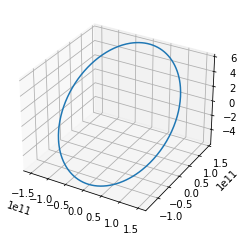

In [22]:
f_sun = plt.figure("Sun")
ax_sun_3d = f_sun.add_subplot(projection='3d')
ax_sun_3d.plot(sun_positions[:, 0], sun_positions[:, 1], sun_positions[:, 2])

In [23]:
np.rad2deg(np.arctan2(sun_positions[0, 1], sun_positions[0, 0]))

-146.35832442727843

In [24]:
thetas_sun = np.arctan2(sun_positions[:, 1], sun_positions[:, 0])

In [25]:
thetas_sun = np.array([theta-2*np.pi if theta>np.pi else theta for theta in thetas_sun ])

In [36]:
ltan_all = thetas_sun - np.array(raan_propagated)

In [37]:
ltan_all = np.array([2*np.pi + ltan  if ltan < 0 else ltan for ltan in ltan_all])

In [38]:
np.rad2deg(thetas_sun[0] - raan_propagated[0])

-270.0

In [39]:
thetas_sun[0]

-2.5544346489580527

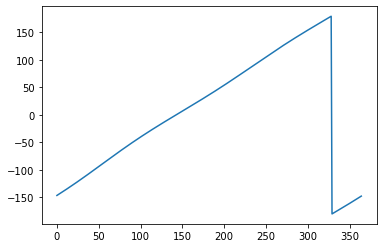

In [40]:
plt.plot(np.rad2deg(thetas_sun))

In [41]:
np.rad2deg(thetas_sun[0])

-146.35832442727843

In [42]:
np.rad2deg(raan_propagated[0])

123.6416755727216

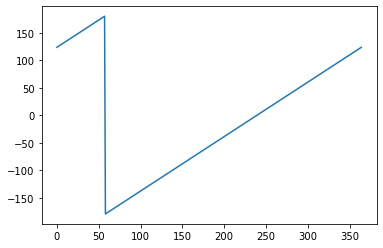

In [43]:
plt.plot(np.rad2deg(raan_propagated))

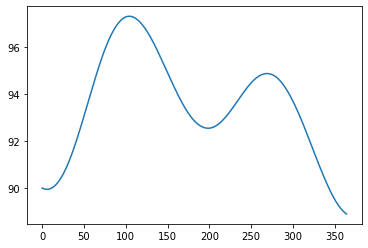

In [44]:
plt.plot(np.rad2deg(ltan_all))